1000268201_693b08cb0e.jpg: ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
1001773457_577c3a7d70.jpg: ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
1002674143_1b742ab4b8.jpg: ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitt

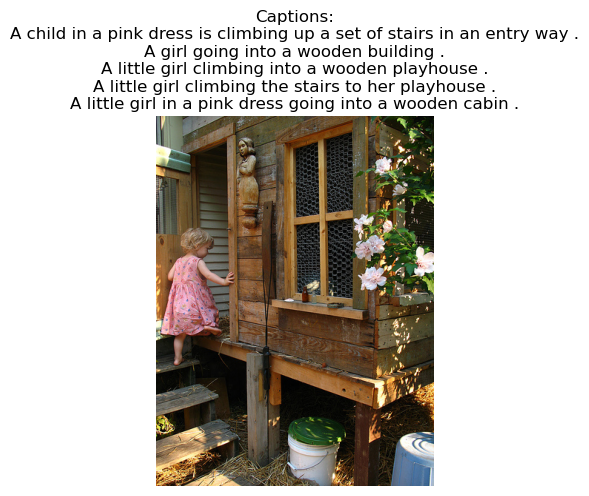

In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Path to the extracted dataset
image_dir = 'Flickr8k_dataset/Flicker8k_Dataset'
annotations_path = 'Flickr8k_text/Flickr8k.token.txt'

# Read the annotations file
with open(annotations_path, 'r') as file:
    annotations = file.readlines()

# Dictionary to store image file names and their corresponding captions
image_captions = {}

# Process each line in the annotations file
for line in annotations:
    parts = line.strip().split('\t')
    if len(parts) == 2:
        image_file, caption = parts
        image_file = image_file.split('#')[0]  # Remove the caption number (e.g., 1000268201_693b08cb0e.jpg#0)
        if image_file not in image_captions:
            image_captions[image_file] = []
        image_captions[image_file].append(caption)

# Print the first 5 entries to verify
for image_file, captions in list(image_captions.items())[:5]:
    print(f"{image_file}: {captions}")
    
# Display an image with its captions
# Select an image file to display
image_file = list(image_captions.keys())[0]  # Taking the first image file as an example
image_path = os.path.join(image_dir, image_file)

# Open and display the image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.title("Captions:\n" + "\n".join(image_captions[image_file]))
plt.show()

In [2]:
import os
import json
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from tqdm.notebook import tqdm
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from nltk.translate.bleu_score import sentence_bleu

# Paths
image_dir = 'Flickr8k_dataset/Flicker8k_Dataset'
annotations_file = 'Flickr8k_text/Flickr8k.token.txt'
train_file = 'Flickr8k_text/Flickr_8k.trainImages.txt'
val_file = 'Flickr8k_text/Flickr_8k.devImages.txt'
test_file = 'Flickr8k_text/Flickr_8k.testImages.txt'

# Read annotations
with open(annotations_file, 'r') as f:
    annotations = f.readlines()

# Create a dictionary for image captions
captions_dict = {}
for line in annotations:
    img_name, caption = line.strip().split('\t')
    img_name = img_name.split('#')[0]
    if img_name not in captions_dict:
        captions_dict[img_name] = []
    captions_dict[img_name].append(caption)

# Load train, val, and test image names
def load_image_names(file_path):
    with open(file_path, 'r') as f:
        return f.read().strip().split('\n')

train_img_names = load_image_names(train_file)
val_img_names = load_image_names(val_file)
test_img_names = load_image_names(test_file)


In [3]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [4]:
# Sample a percentage of the training and validation data
def sample_data(img_names, percentage):
    sample_size = int(len(img_names) * percentage)
    return random.sample(img_names, sample_size)

train_img_names = sample_data(train_img_names, 0.03)  # Sample 3% of images for training
val_img_names = sample_data(val_img_names, 0.03)  # Sample 3% of images for validation

# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# Define collate_fn function
def collate_fn(data):
    images, captions = zip(*data)
    images = torch.stack(images, 0)
    
    # Tokenize captions
    tokenizer = lambda x: x.split()  # Simple whitespace tokenizer, you can replace it with your tokenizer
    captions = [tokenizer(caption) for caption in captions]
    
    # Convert each caption list to a tensor
    captions = [torch.tensor(caption) for caption in captions]
    
    return images, captions

class Flickr8kDataset(Dataset):
    def __init__(self, img_names, captions_dict, img_dir, transform=None):
        self.img_names = img_names
        self.captions_dict = captions_dict
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        captions = self.captions_dict[img_name]
        return image, captions

# Create dataset objects
train_dataset = Flickr8kDataset(train_img_names, captions_dict, image_dir, transform)
val_dataset = Flickr8kDataset(val_img_names, captions_dict, image_dir, transform)
test_dataset = Flickr8kDataset(test_img_names, captions_dict, image_dir, transform)

# Create data loaders with collate_fn
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)


In [5]:
# Check if GPU is available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Encoder model using MobileNet
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        super(EncoderCNN, self).__init__()
        mobilenet = models.mobilenet_v2(pretrained=True)
        for param in mobilenet.parameters():
            param.requires_grad = False
        self.mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])
        self.linear = nn.Linear(mobilenet.classifier[1].in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
    
    def forward(self, images):
        features = self.mobilenet(images).reshape(images.size(0), -1)
        features = self.bn(self.linear(features))
        return features

# Decoder model
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
    
    def forward(self, features, captions):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs
    
    def sample(self, features, states=None, max_len=20):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(max_len):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids

# Instantiate encoder and decoder
embed_size = 256
hidden_size = 512
vocab_size = 5000  # Update based on your vocabulary size
num_layers = 1
encoder = EncoderCNN(embed_size).to(device)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers).to(device)


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\Anna Roy/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:02<00:00, 6.76MB/s]


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = optim.Adam(params, lr=0.001)

# Training loop
num_epochs = 5
log_step = 5

for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    for i, (images, captions) in enumerate(train_loader):
        images = images.to(device)
        captions = captions.to(device)
        
        features = encoder(images)
        outputs = decoder(features, captions[:, :-1])
        loss = criterion(outputs.reshape(-1, vocab_size), captions[:, 1:].reshape(-1))
        
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        
        if i % log_step == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i}/{len(train_loader)}], Loss: {loss.item():.4f}')


In [ ]:
# Evaluation function
def evaluate(model, loader):
    model.eval()
    total_bleu1, total_bleu2, total_bleu3, total_bleu4 = 0, 0, 0, 0
    with torch.no_grad():
        for images, captions in loader:
            images = images.to(device)
            features = encoder(images)
            outputs = decoder.sample(features)
            
            for i, output in enumerate(outputs):
                reference = [c.split() for c in captions[i]]
                candidate = output.split()
                total_bleu1 += sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
                total_bleu2 += sentence_bleu(reference, candidate, weights=(0.5, 0.5, 0, 0))
                total_bleu3 += sentence_bleu(reference, candidate, weights=(0.33, 0.33, 0.33, 0))
                total_bleu4 += sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
    
    return total_bleu1/len(loader), total_bleu2/len(loader), total_bleu3/len(loader), total_bleu4/len(loader)

# Evaluation
bleu1, bleu2, bleu3, bleu4 = evaluate(decoder, test_loader)
print(f'BLEU-1: {bleu1}, BLEU-2: {bleu2}, BLEU-3: {bleu3}, BLEU-4: {bleu4}')
